In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pydicom
import scipy.ndimage

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import HTML

import warnings 
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

from os import listdir

In [3]:
basepath = "../input/osic-pulmonary-fibrosis-progression/"
listdir(basepath)

['train', 'test', 'test.csv', 'sample_submission.csv', 'train.csv']

In [4]:
train = pd.read_csv(basepath + "train.csv")
test = pd.read_csv(basepath + "test.csv")

In [5]:
def load_scans(dcm_path):
    slices = [pydicom.dcmread(dcm_path + "/" + file) for file in listdir(dcm_path)]
    slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    return slices

In [6]:
example = basepath + "train/" + train.Patient.values[0]
scans = load_scans(example)

In [7]:
scans[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.95516132172461492040664114239048418896
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.95516132172461492040664114239048418896
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

In [8]:
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    images[images == -2000] = 0
    for n in range(len(slices)):
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.int16)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    return np.array(images, dtype = np.int16)

In [9]:
hu_scans = transform_to_hu(scans)


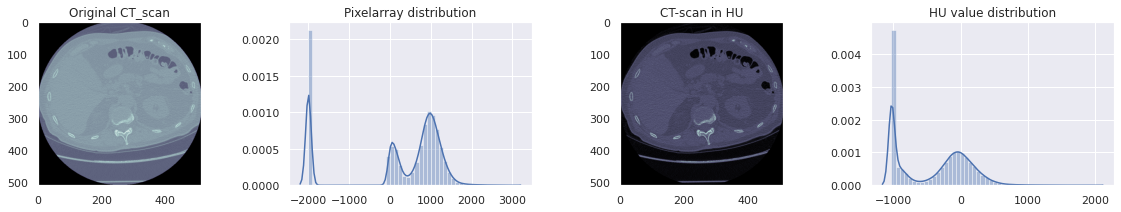

In [10]:
fig, ax = plt.subplots(1,4, figsize = (20, 3))
ax[0].set_title('Original CT_scan')
ax[0].imshow(scans[0].pixel_array, cmap = 'bone')
ax[1].set_title('Pixelarray distribution')
sns.distplot(scans[0].pixel_array.flatten(), ax = ax[1])

ax[2].set_title('CT-scan in HU')
ax[2].imshow(hu_scans[0], cmap = 'bone')
ax[3].set_title('HU value distribution')
sns.distplot(hu_scans[0].flatten(), ax = ax[3])

for m in [0, 2]:
    ax[m].grid(False)

In [11]:
collection = []
for m in range(20):
    example = basepath + 'train/' + train.Patient.values[m]
    scans = load_scans(example)
    pixel_spacing = scans[0].PixelSpacing
    collection.append(pixel_spacing)

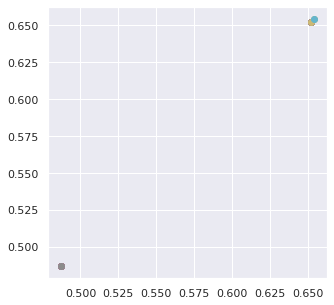

In [13]:
plt.figure(figsize = (5, 5))
for n in range(len(collection)):
    plt.scatter(collection[n][0], collection[n][1])

In [39]:
def resample(image, scan, new_spacing = [1, 1, 1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode = 'nearest')
    
    return image, new_spacing
    
    

In [40]:
pix_resampled, spacing = resample(hu_scans, scans, [1,1,1])


In [41]:
example = basepath + 'train/' + train.Patient.values[20]
scans = load_scans(example)
hu_scans = transform_to_hu(scans)


In [56]:
def plot_3d(image, threshold = 700, color = 'navy'):
    p = image.transpose(2,1,0)
    verts, faces, _,_ = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection = '3d')
    
    mesh = Poly3DCollection(verts[faces], alpha = 0.5)
    mesh.set_edgecolor(color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    plt.show()
    

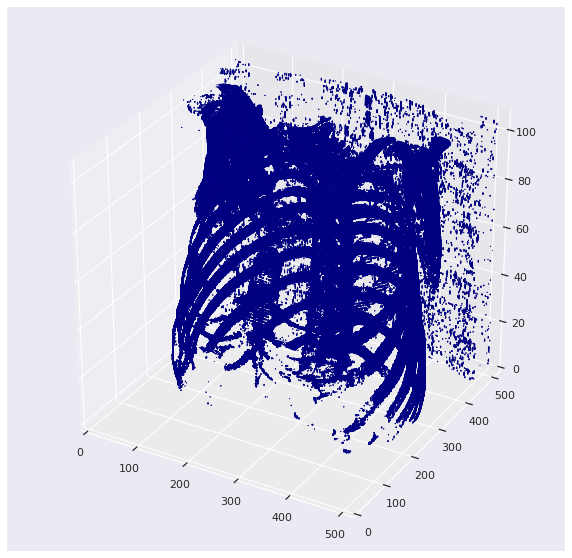

In [57]:
plot_3d(hu_scans)

In [73]:
def largest_label_volume(im, bg = -1):
    vals, counts = np.unique(im,return_counts = True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_tissue(image, threshold = -300, fill_lung_structures = True):
    labelled_image = np.array(image > threshold, dtype = np.int8) + 1
    labels = measure.label(labelled_image)
    
    background_label = labels[0, 0]
    labelled_image[background_label == labels] = 2
    
    labelled_image -= 1
    labelled_image = 1 - labelled_image
    
    if fill_lung_structures:
        for i, axial_slice in enumerate(labelled_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg = 0)
            
            if l_max is not None:
                labelled_image[i][labeling != l_max] = 1
    labels = measure.label(labelled_image, background = 0)
    l_max = largest_label_volume(labels, bg = 0)
    if l_max is not None:
        labelled_image[labels != l_max] = 0
        
    return labelled_image
    
    

In [74]:
segmented_lungs = segment_tissue(hu_scans, fill_lung_structures = False)
segmented_lungs_fill = segment_tissue(hu_scans, fill_lung_structures = True)


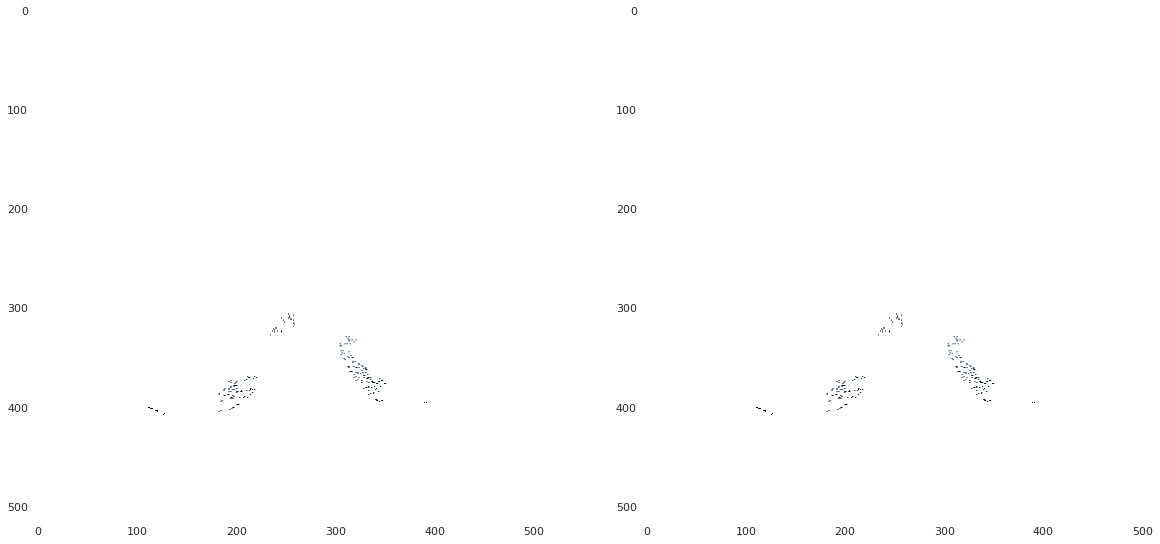

In [75]:
fig, ax = plt.subplots(1,2, figsize = (20, 10))
ax[0].imshow(segmented_lungs[20], cmap = 'bone_r')
ax[1].imshow(segmented_lungs_fill[20], cmap = 'bone_r')
for n in range(2):
    ax[n].grid(False)

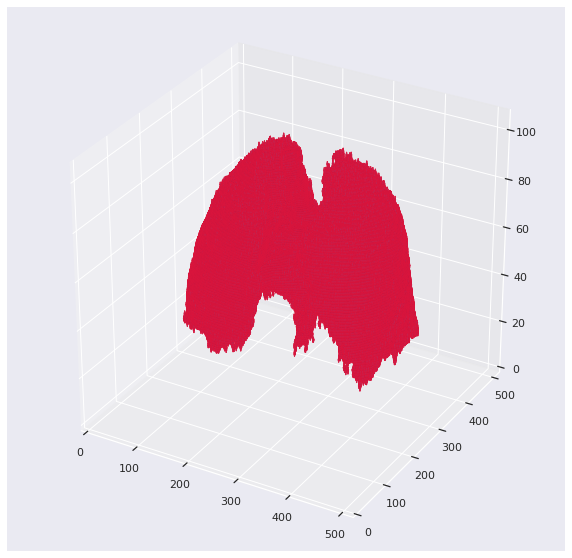

In [76]:
plot_3d(segmented_lungs_fill, threshold = 0, color = 'crimson')

In [77]:
plot_3d(segmented_lungs_fill - segmented_lungs, threshold = 0, color = 'crimson')

NameError: name 'semented_lungs' is not defined